In [1]:
import math
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
from ipywidgets import IntProgress
from IPython.display import display
import time

np.random.seed(1)

def scale_sample(par_r, par_z, par_a):
    
    [r_min, r_max, z_min, z_max] = par_a
        
    # Scale the variables to the sampling area
    dist_r = r_max - r_min
    dist_z = z_max - z_min

    r = (dist_r * par_r) + r_min
    z = (dist_z * par_z) + z_min
        
    return r, z

def total_area(par_a):
    '''
    define the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    
    return (r_max - r_min) * (z_max - z_min)

def total_samplecount(par_a,par_d):
    '''
    define the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    r_len = (r_max - r_min)/par_d
    z_len = (z_max - z_min)/par_d
    return  r_len* z_len




def mandelbrot_area(par_mandel,par_sizecount,par_area):
    '''
    define the sampling area
    '''
    if par_sizecount == 0:
        return 0
    if par_mandel.ndim < 1:
        return par_mandel
    elif  par_mandel.ndim == 1:
        mandel_in_area = sum(1-par_mandel)
    elif  par_mandel.ndim == 2:
        mandel_in_area = sum(sum(1-par_mandel)) 
    elif  par_mandel.ndim == 3:
        mandel_in_area = sum(sum(sum(1-par_mandel)))
    elif  par_mandel.ndim >3:
        print("too many dimensions!")
        return 0
    ret_area = (mandel_in_area/par_sizecount) * par_area
    return  ret_area


def grid(par_a, par_d):
    '''
    define grid for the sampling area
    '''
    [r_min, r_max, z_min, z_max] = par_a
    
    r_axis = np.arange(r_min, r_max + par_d, par_d)
    z_axis = np.arange(z_min, z_max + par_d, par_d)
    
    zz, rr = np.meshgrid(z_axis, r_axis)
    
    return zz, rr

def mandel(par_x,par_c):
    '''
    next step in mandelbrot iteration
    '''
    [x_r,x_z] = par_x
    [c_r,c_z] = par_c
    
    return [x_r**2 - x_z**2 + c_r, 2 * x_r * x_z + c_z]


def mandel_cond(par_x):
    '''
    define the breaking condition
    '''
    [x_r,x_z] = par_x
    
    magn = (x_r**2 + x_z**2)**0.5
    if magn > 2:
        return 1
    
    return 0
    
           
           
def mandel_i(par_c,par_i):
    '''
    define the iteration loop breaking after i iterations
    '''
    x = [0, 0]
    for _ in range(par_i):
        x = mandel(x, par_c)
        
        cond = mandel_cond(x)
        if cond:
            return 1
    
    return 0
    
    
def mandel_a(par_a, par_i, par_d):
    '''
    define the iteration loop for a square of size a with spacing d
    '''
    [r_min, r_max, z_min, z_max] = par_a
    r_axis = np.arange(r_min, r_max + par_d, par_d)
    z_axis = np.arange(z_min, z_max + par_d, par_d)
    
    plane = np.zeros((len(r_axis), len(z_axis)))
    
    for r in range(len(r_axis)):
        for z in range(len(z_axis)):
            c = [r_axis[r], z_axis[z]]
            
            result = mandel_i(c, par_i)
            plane[r, z] = result
    
    return plane   


def subspacing(par_a,par_subspaces):
    
    ret_subareas = np.zeros(np.append(par_subspaces,4))
    [r_min, r_max, z_min, z_max] = par_a
    loc_subarea = np.zeros((par_subspaces[0],4))
    if par_subspaces[0]%2 ==0:
        r_span = (r_max - r_min) /(par_subspaces[0]/2)
        z_span = (z_max - z_min) /2
    elif (r_max - r_min)<(z_max - z_min):
        r_span = (r_max - r_min)
        z_span = (z_max - z_min) /(par_subspaces[0])
    else:
        r_span = (r_max - r_min) /(par_subspaces[0])
        z_span = (z_max - z_min)

    for i in range(par_subspaces[0]):
        
        if par_subspaces[0]%2 ==0:
            loc_r_i = math.floor(i/2)
            loc_z_i = i%2
        elif (r_max - r_min)<(z_max - z_min):
            loc_r_i = 0
            loc_z_i = i
        else:
            loc_r_i = i
            loc_z_i = 0
            
        loc_subarea[i] =  [r_min+ r_span*loc_r_i,r_min+ r_span*(loc_r_i+1) ,z_min+ z_span*loc_z_i,z_min+ z_span*(loc_z_i+1) ]
        
        if len(par_subspaces) == 1:
            
            ret_subareas[i] = loc_subarea[i]
        else:
            ret_subareas[i] = subspacing(loc_subarea[i],par_subspaces[1:])
    return ret_subareas
    
    
def func_i(par_samples,par_a,par_i):
    '''
    Define function consdering the amount of maximal iterations 
    returning its specific area
    '''
    
    loc_tot_area = total_area(par_a)
    loc_sizecount = len(par_samples)
    loc_mandel = np.zeros(loc_sizecount)
    for loc_j in range(loc_sizecount):
        loc_mandel[loc_j] =  mandel_i(par_samples[loc_j], par_i)
        
    ret_area = mandelbrot_area(loc_mandel,loc_sizecount,loc_tot_area)
    return ret_area
    



    
def func_j_i(par_samples,par_a,par_i):
    '''
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_i) # instantiate the bar
    display(f)
    ret_area = []
    for loc_j in range(par_i):
        f.value +=1
        ret_area.append(func_i(par_samples,par_a,loc_j))
    return ret_area


def func_s_log_uni(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    pure random sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        loc_samples = np.empty((sample_size,2))
        
        #######
        #create sample array(start)
        ######
        for loc_sub_s in range(sample_size):
            
            loc_r = (par_a[1]-par_a[0]) * np.random.rand() + par_a[0]
            loc_z = (par_a[3]-par_a[2]) * np.random.rand() + par_a[2]
            
            loc_samples[loc_sub_s] = [loc_r,loc_z]
        
        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)

def random_permutation(array):
    # Set index k equal to the final element in the array
    k = len(array) - 1
    
    while k > 1:
        element = array[k]
        # Generate random index to swap with index k
        index = int(k * np.random.uniform()) + 1
        array[k] = array[index]
        array[index] = element
        
        k -= 1
    
    return array

def latin_hypercube_sampling_1d(par_s):
    '''
    function that returns s sampling points each in an interval [j/s, (j+1)s] with j = 0, 1, ..., s-1
    '''

    samples = np.zeros(par_s)
    for s in range(par_s):
        samples[s] = (s + np.random.uniform()) / n
        
    return samples
    
def latin_hypercube_sampling_2d(par_s):
    '''
    function that returns a latin hypercube of sampling points in 2 dimensions
    '''
    
    # Array to store the sampling points
    samples = np.zeros((par_s, 2))
    
    x = random_permutation(latin_hypercube_sampling_1d(par_s))
    y = random_permutation(latin_hypercube_sampling_1d(par_s))
    
    # Combine the x and y coordinate to form a sampling point
    for s in range(par_s):
        index_x = 0
        index_y = 0
        # Sampling points are not allowed to be on the same row or column
        if math.trunc(y[index_y] * par_s) == math.trunc(x[index_y] * par_s):
            # Generate a random index to swap with
            index_y = int((len(y) - 1) * np.random.uniform())
            if index_y == 0:
                index_y += 1
        
        # Add sampling point to the array
        samples[s, 0] = x[index_x]
        samples[s, 1] = y[index_y]
        
        # Delete the used coordinates, so they cannot be used in the swap anymore
        x = np.delete(x, index_x)
        y = np.delete(y, index_y)

    return samples

def func_s_log_latin(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    latin hypercube sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        
        #######
        #create sample array(start)
        ######
        
        loc_samples = latin_hypercube_sampling_2d(loc_s)

        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)


def ortho_sampling(par_subspacing,par_sample_size):
    ret_samples = np.empty((0,2))
    loc_subspace_dim = np.shape(par_subspacing)
    #get the amount of samples per subspace 
    loc_samples_per_subspace = par_sample_size/loc_subspace_dim[0]
    loc_samples_collected = 0
    for loc_sub_s in range(loc_subspace_dim[0]):
        loc_sample_for_subspace = max([0,math.ceil((loc_samples_per_subspace * (loc_sub_s+1))-loc_samples_collected )])
        if len(loc_subspace_dim) ==2:
            for j in range(loc_sample_for_subspace):
                loc_r = (par_subspacing[loc_sub_s][1]-par_subspacing[loc_sub_s][0]) * np.random.rand() + par_subspacing[loc_sub_s][0]
                loc_z = (par_subspacing[loc_sub_s][3]-par_subspacing[loc_sub_s][2]) * np.random.rand() + par_subspacing[loc_sub_s][2]
                #ret_samples[loc_samples_collected+ loc_sub_s] = [loc_r,loc_z]
                ret_samples = np.append(ret_samples,[[loc_r,loc_z]],axis=0)
        else:
            ret_samples = np.append(ret_samples,ortho_sampling(par_subspacing[loc_sub_s],loc_sample_for_subspace),axis=0)
        loc_samples_collected += loc_sample_for_subspace
    return ret_samples


def func_s_log_ortho(par_a,par_i,par_s,par_i_range=False,par_s_range=False):
    '''
    pure random sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.empty((par_s,par_i))
    elif par_i_range == True:
        ret_area = np.empty((1,par_i))
    elif par_s_range == True:
        ret_area = np.empty((par_s,1))
    else:
        ret_area = np.empty((1,1))
        
        
    if par_s_range == True:
        start_s = 1
    else:
        start_s = par_s
    
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size = 2**loc_s
        loc_samples = np.empty((sample_size,2))
        
        #######
        #create sample array(start)
        ######
        subspace_dim = [4,4]
        loc_subspacing = subspacing(par_a,subspace_dim)
        loc_samples = ortho_sampling(loc_subspacing,sample_size)
        
        #######
        #create sample array(end)
        ######
        
        #enter sample array to 
        
        if par_i_range == True:
            loc_temp_result = func_j_i(loc_samples,par_a,par_i)
            ret_area[loc_s-start_s] = loc_temp_result - loc_temp_result[-1]
        else:
            ret_area[loc_s-start_s] = func_i(loc_samples,par_a,par_i)
        
        
    if par_s_range == True and par_i_range ==False:
        ret_area = ret_area - ret_area[-1]
        
    return abs(ret_area)




def func_s_d_latin(par_a,par_i,par_s, par_method):
    '''
    latin square sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_i+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    mandelbrot_a = []
    
    if par_method == 'latin_hypercube':
        # Create s samples (in [0, 1)
        sampler = qmc.LatinHypercube(d=2)
        samples = sampler.random(par_s)
    
    for loc_j in range(par_i + 1):
        f.value +=1
        
        # Counter for the number of samples in the mandelbrot area
        inside = 0
        
        for s in range(par_s):

            if par_method == 'uniform':
                # Random uniform variables
                r = np.random.uniform()
                z = np.random.uniform()

            elif par_method == 'latin_hypercube':
                # Pick from the next sample in the list
                r = samples[s][0]
                z = samples[s][1]

            # Scale the variables to the sampling area
            r, z = scale_sample(r, z, par_a)
            
            if mandel_i([r, z], loc_j) == 0:
                inside += 1
        
        mandelbrot_a.append((inside/par_s) * loc_tot_area)

    return mandelbrot_a




In [2]:

'''
Idea:
create a subspace with dimensions 4^n 
set corresponding matrix entry to a pprobability and iteration
iteration step 0
    create 4 subspace set probability to 1/4
    
        multiply probability with amount of samples floor min 1 .
        count samples in the end
        
    iterate over the subspaces 
        and in the subspaces over the samples. 
            test for convergence with amount of iterations
        if all samples in subspace are either in or out of the set reduce probability by 50% and mark as such. 
        if all are in the set, also reduce the iterations necessary.
        calculate the mandelbrot area in the subspace.
        Accumulate the percentage and the amount of subspaces with penalty.
    iterate over subspaces again
        distribute the leftover percentage among the rest of the subspaces 
        increase the amount of iterations in (most) subspaces 
    if counter for iteration %4 == 0 
        create another subspace in each subspace
'''

    
def func_i_inout(par_samples,par_a,par_i):
    '''
    Define function consdering the amount of maximal iterations 
    returning its specific area
    '''
    
    loc_tot_area = total_area(par_a)
    loc_sizecount = len(par_samples)
    loc_mandel = np.zeros(loc_sizecount)
    for loc_j in range(loc_sizecount):
        loc_mandel[loc_j] =  mandel_i(par_samples[loc_j], par_i)
        
    ret_area = mandelbrot_area(loc_mandel,loc_sizecount,loc_tot_area)
    all_out, all_in = [0,0]
    #print("samples inout",loc_mandel)
    #print("parameters",par_samples,par_a,par_i)
    if sum(loc_mandel) ==loc_sizecount:
        all_in =1
        all_out=0
    elif sum(loc_mandel) ==0:
        all_out =1
        all_in =0
    else:
        
        all_out=0
        all_in =0
        
    return ret_area, all_in,all_out
    



    
def func_j_i_inout(par_samples,par_a,par_i):
    '''
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_i) # instantiate the bar
    display(f)
    ret_area = []
    for loc_j in range(int(par_i)):
        f.value +=1
        ret_area.append(func_i(par_samples,par_a,loc_j))
    all_out, all_in = [0,0]
    if sum(loc_mandel) ==loc_sizecount:
        all_in =1
    elif sum(loc_mandel) ==0:
        all_out =1
        
    return ret_area, all_in,all_out


def matrixmapper(par_mat,par_number):
    goal = np.shape(par_mat)
    if len(goal)>1:
        ret = 1
        for i in goal[1:]:
            ret = ret*i
            
        new_num = par_number%ret
        new_subarr = math.floor(par_number/ret)
        retval = matrixmapper(par_mat[new_subarr],new_num)
    else:
        retval = par_mat[par_number]
    
    return retval
        

def matrixwriter(par_mat,par_number,insert):
    goal = np.shape(par_mat)
    retval = par_mat
    if len(goal)>1:
        ret = 1
        for i in goal[1:]:
            ret = ret*i
            
        new_num = par_number%ret
        new_subarr = math.floor(par_number/ret)
        matrixwriter(par_mat[new_subarr],new_num,insert)
    else:
        retval[par_number] = insert
    
    return retval
        


def func_s_log_zoom(par_a,par_i,par_s,par_subdiv= 4,par_i_range=False,par_s_range=False,save_samples =False):
    '''
    pure random sampling
    Define function considering the improvement after j steps
    returning the area for all precisions until i
    '''
    f = IntProgress(min=0, max=par_s+1) # instantiate the bar
    display(f)
    loc_tot_area = total_area(par_a)
    
    if par_i_range == True and par_s_range == True:
        ret_area = np.zeros(par_s)
    elif par_i_range == True:
        ret_area = np.zeros(par_s)
    elif par_s_range == True:
        ret_area = np.zeros(par_s)
    else:
        ret_area = np.zeros((1,1))
        
        
    if par_s_range == True:
        start_s =1
    else:
        start_s = par_s 

    #INstantiate handover subspace parameters
    n_increase_after_iteration = 2
    glo_split =par_subdiv
    glo_check_iterations =par_i
    
    loc_subspace_param = np.append(np.zeros((1,glo_split)) + 1/glo_split,np.zeros((2,glo_split)),axis =0)
    
    if par_i_range ==True:
        loc_subspace_param[1] = glo_check_iterations
        
    else:
        loc_subspace_param[1] = int(par_i)
        loc_iterations_next_cycle =int(par_i)
    
    if save_samples ==True:
        saved_samples = np.zeros((1,2))
        
    #for surrounding iterations
    for loc_s in range(start_s,par_s+1):
        f.value = loc_s
        sample_size_param = 2**(loc_s+7)
        if par_i_range ==True:
            loc_iterations_next_cycle = glo_check_iterations * (loc_s)
        
        subspace_dim = [glo_split]*(math.ceil(loc_s/n_increase_after_iteration))
        next_subspace_dim = [glo_split]*(math.ceil((loc_s+1)/n_increase_after_iteration))
        
        
        loc_new_subspace_param = np.zeros(np.append(3,next_subspace_dim))
        
        loc_subspacing = subspacing(par_a,subspace_dim)
        
        #Iterate through all subspaces
        loc_num_subspace = glo_split**len(subspace_dim)
        next_loc_num_subspace = glo_split**len(next_subspace_dim)
        new_percent = 0
        total_samples = 0
        total_percentage = 0
        for loc_subspace in range(loc_num_subspace):
            loc_percentage = matrixmapper(loc_subspace_param[0],loc_subspace)
            loc_samples_size = max(1,math.floor(loc_percentage* sample_size_param))
            loc_iterations = matrixmapper(loc_subspace_param[1],loc_subspace)
            loc_subspacearea = np.zeros(4)
            loc_subspacearea[0] = matrixmapper(loc_subspacing,loc_subspace*4)
            loc_subspacearea[1] = matrixmapper(loc_subspacing,loc_subspace*4+1)
            loc_subspacearea[2] = matrixmapper(loc_subspacing,loc_subspace*4+2)
            loc_subspacearea[3] = matrixmapper(loc_subspacing,loc_subspace*4+3)
                
            loc_samples = np.empty((loc_samples_size,2))

            #######
            #create sample array(start)
            ######
            total_samples +=loc_samples_size
            for loc_sub_s in range(loc_samples_size):

                loc_r = (loc_subspacearea[1]-loc_subspacearea[0]) * np.random.rand() + loc_subspacearea[0]
                loc_z = (loc_subspacearea[3]-loc_subspacearea[2]) * np.random.rand() + loc_subspacearea[2]

                loc_samples[loc_sub_s] = [loc_r,loc_z]
            #
            if save_samples ==True:
                saved_samples = np.append(saved_samples,
                                          loc_samples,axis = 0)
            #######
            #create sample array(end)
            ######


            loc_area_result,all_in,all_out = func_i_inout(loc_samples,par_a,int(loc_iterations))
                
            
            if all_in == 1:
                matrixwriter(loc_subspace_param[2],loc_subspace,1)
                new_percent += loc_percentage/2
                matrixwriter(loc_subspace_param[0],loc_subspace,loc_percentage/2)
            elif all_out == 1:
                matrixwriter(loc_subspace_param[2],loc_subspace,1)
                new_percent += loc_percentage/2
                matrixwriter(loc_subspace_param[0],loc_subspace,loc_percentage/2)
                matrixwriter(loc_subspace_param[1],loc_subspace,loc_iterations_next_cycle)
            else:
                matrixwriter(loc_subspace_param[1],loc_subspace,loc_iterations_next_cycle)
                matrixwriter(loc_subspace_param[2],loc_subspace,0)
                
                
                
            ret_area[loc_s-start_s] += loc_area_result/loc_num_subspace

            total_percentage += loc_percentage
                
        
        if(loc_s<par_s):

            loc_zoomspace_count = np.sum(1-loc_subspace_param[2])


            if abs(loc_zoomspace_count ) < 1:
                loc_subspace_param[2] = np.zeros(subspace_dim)
                loc_zoom_percentage = 1/loc_num_subspace
            else:
                loc_zoom_percentage = (1 - new_percent)/loc_zoomspace_count

            for loc_subspace in range(loc_num_subspace):

                if matrixmapper(loc_subspace_param[2],loc_subspace) ==1:
                    new_param = matrixmapper(loc_subspace_param[0],loc_subspace)
                    loc_new_iterations_for_subspace = matrixmapper(loc_subspace_param[1],loc_subspace)
                else:
                    new_param = loc_zoom_percentage
                    loc_new_iterations_for_subspace = matrixmapper(loc_subspace_param[1],loc_subspace)

                if loc_num_subspace < next_loc_num_subspace:
                    for m in range(glo_split):
                        matrixwriter(loc_new_subspace_param[0],loc_subspace*glo_split+m,new_param/glo_split)
                        matrixwriter(loc_new_subspace_param[1],loc_subspace*glo_split+m,loc_new_iterations_for_subspace)
                else:
                    matrixwriter(loc_new_subspace_param[0],loc_subspace,new_param)
                    matrixwriter(loc_new_subspace_param[1],loc_subspace,loc_new_iterations_for_subspace)

            loc_subspace_param = loc_new_subspace_param.copy()

    if save_samples:
        return abs(ret_area), saved_samples
    else:
        return abs(ret_area)




In [7]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 200
Samples = 8
#np.random.seed(1337)
repeats = 10
import timeit

area_estimates_ortho_i = np.zeros((repeats,Samples))
area_estimates_ortho_i_n = np.zeros((repeats,Samples))
for i in range(repeats):
    print(i,"/",repeats)
    start_time = time.time()
    timeit.timeit('"-".join(str(n) for n in range(100))', number=10000)
    area_estimates_ortho_i[i]= func_s_log_zoom(area,Iterations,Samples,par_subdiv=4,par_i_range=True,par_s_range=True,save_samples=False)

    area_estimates_ortho_i_n[i]= func_s_log_zoom(area,Iterations,Samples,par_subdiv=1,par_i_range=True,par_s_range=True,save_samples=False)
    print("--- %s seconds ---" % (time.time() - start_time))

0 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 84.3629961013794 seconds ---
1 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 86.61072492599487 seconds ---
2 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 85.60621166229248 seconds ---
3 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 85.41921496391296 seconds ---
4 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 82.97204685211182 seconds ---
5 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 82.71333837509155 seconds ---
6 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 83.40496158599854 seconds ---
7 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 84.48435950279236 seconds ---
8 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 83.57432055473328 seconds ---
9 / 10


IntProgress(value=0, max=9)

IntProgress(value=0, max=9)

--- 85.01182579994202 seconds ---


In [8]:
num_mandelbrot_area = 1.506484
mean_area_estimate_ortho_i = np.mean(area_estimates_ortho_i,axis=0)
mean_area_estimate_ortho_i_n = np.mean(area_estimates_ortho_i_n,axis=0)

std_area_estimate_ortho_i = np.std(area_estimates_ortho_i,axis=0)
std_area_estimate_ortho_i_n = np.std(area_estimates_ortho_i_n,axis=0)


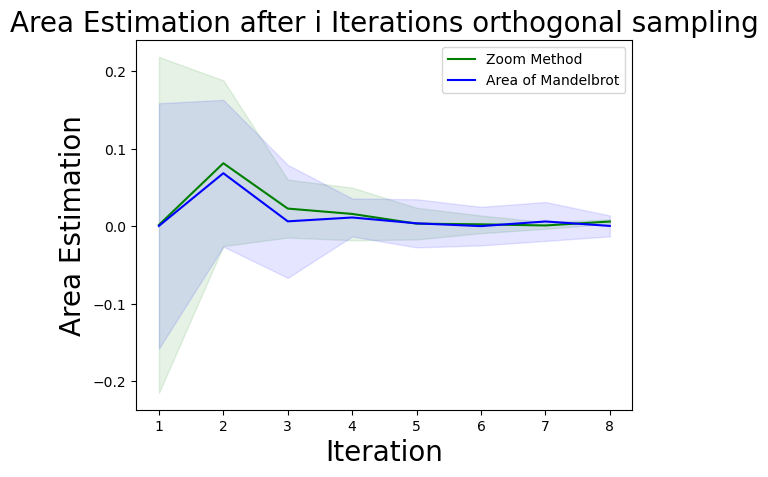

In [9]:
values_1 = abs(mean_area_estimate_ortho_i-num_mandelbrot_area)
values_2 = abs(mean_area_estimate_ortho_i_n-num_mandelbrot_area)

fig, ax = plt.subplots()
plt.plot(np.arange(8)+1,values_1,'g-',label= "Zoom Method")
plt.plot(np.arange(8)+1,values_2,'b-',label= "Area of Mandelbrot")
ax.fill_between(np.arange(8)+1, (values_1-std_area_estimate_ortho_i), (values_1+std_area_estimate_ortho_i), color='g', alpha=.1)
ax.fill_between(np.arange(8)+1, (values_2-std_area_estimate_ortho_i_n), (values_2+std_area_estimate_ortho_i_n), color='b', alpha=.1)
plt.title("Area Estimation after i Iterations random sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

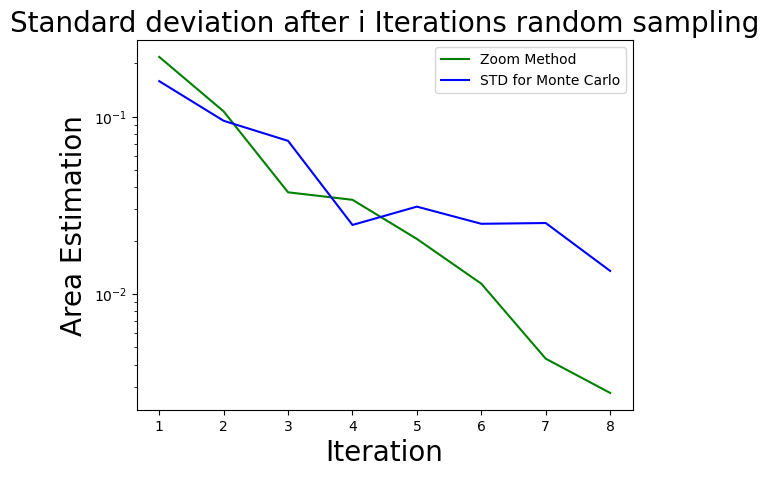

In [11]:
values_1 = abs(mean_area_estimate_ortho_i-num_mandelbrot_area)
values_2 = abs(mean_area_estimate_ortho_i_n-num_mandelbrot_area)

fig, ax = plt.subplots()
plt.semilogy(np.arange(8)+1,std_area_estimate_ortho_i,'g-',label= "Zoom Method")
plt.semilogy(np.arange(8)+1,std_area_estimate_ortho_i_n,'b-',label= "STD for Monte Carlo")
plt.title("Standard deviation after i Iterations random sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

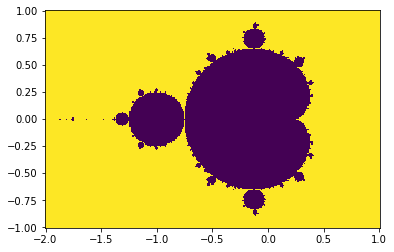

In [34]:
'''
Hypothesis:
The method used in calculating the area is converging faster to the predicted true value than the Monte carlo method.

Null hypothesis
the difference in convergence comes down to pure chance.
Test for decreasing std as well as increasing accuracy

ftest


'''
    

In [32]:
area_estimate = func_j_i(area, 1000, 1000, 'uniform')

IntProgress(value=0, max=1001)

In [33]:
area_estimate[-1]

1.422

In [10]:
loc_sizecount = total_samplecount(area,spacing)
mandelbrot_area(mandel_plane,loc_sizecount,total_area(area))

1.5081000000000002

In [163]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 500
Samples = 15
np.random.seed(1337)
area_estimate_uni_s = func_s_log_uni(area,Iterations,Samples,par_i_range=False,par_s_range=True)

IntProgress(value=0, max=16)

KeyboardInterrupt: 

In [ ]:

plt.semilogy(area_estimate_uni_s,'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after with 2^n universal samples",size=20)
plt.xlabel('2^n universal-samples',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [ ]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 50
Samples = 10
np.random.seed(1337)
area_estimate_uni_i = func_s_log_uni(area,Iterations,Samples,par_i_range=True,par_s_range=False)

In [ ]:

plt.semilogy(area_estimate_uni_i[0],'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after i Iterations universal sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [164]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 500
Samples = 15
np.random.seed(1337)
area_estimate_ortho_s = func_s_log_ortho(area,Iterations,Samples,par_i_range=False,par_s_range=True)

IntProgress(value=0, max=16)

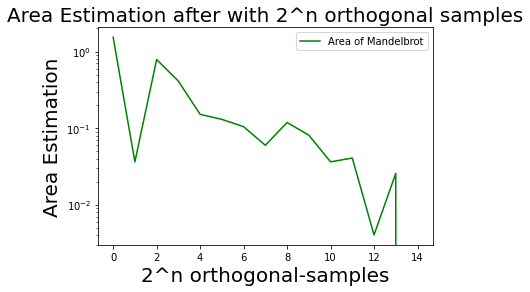

In [165]:

plt.semilogy(area_estimate_ortho_s,'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after with 2^n orthogonal samples",size=20)
plt.xlabel('2^n orthogonal-samples',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [166]:
area = [-2, 1, -1, 1]     # Edges of the area
Iterations = 50
Samples = 10
np.random.seed(1337)
area_estimate_ortho_i = func_s_log_ortho(area,Iterations,Samples,par_i_range=True,par_s_range=False)

IntProgress(value=0, max=11)

IntProgress(value=0, max=50)

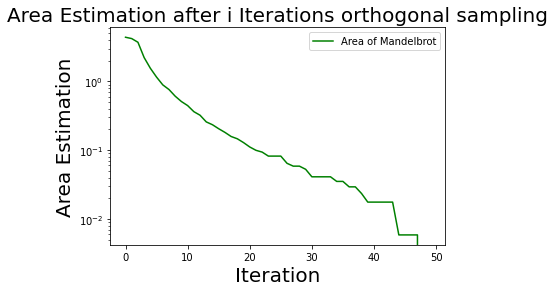

In [167]:

plt.semilogy(area_estimate_ortho_i[0],'g-',label= "Area of Mandelbrot")
plt.title("Area Estimation after i Iterations orthogonal sampling",size=20)
plt.xlabel('Iteration',size=20)
plt.ylabel('Area Estimation',size=20)
plt.legend()
#fig.savefig('figure1.png', dpi=300)
plt.show()

In [19]:
#area = [-2, 1, -1, 1]
#n_arr = 132726
import numpy as np
samples_in_arr = [0,256,512,1024,2041,4056,8152,16336,32726,65092,130678,262092,523983,1055024,2103114,4229692]

ccolors = ["k.","k.","c.","b.","g.","y.","m.","r.","c.","b.","g.","y.","m.","r."]
cumulative_samples = np.cumsum(samples_in_arr)


In [20]:
len(ccolors)

14

In [26]:
np.random.randint(samples_in_arr[1],samples_in_arr[2],256)

array([341, 434, 492, 441, 383, 315, 457, 296, 319, 448, 390, 256, 301,
       302, 499, 364, 431, 264, 373, 465, 384, 463, 308, 439, 372, 388,
       289, 258, 478, 453, 467, 352, 420, 413, 264, 413, 468, 452, 345,
       448, 285, 478, 428, 461, 481, 265, 409, 351, 316, 294, 403, 348,
       425, 346, 429, 345, 361, 401, 350, 503, 480, 498, 258, 300, 346,
       302, 411, 377, 401, 385, 344, 338, 473, 394, 330, 378, 506, 395,
       405, 415, 504, 359, 444, 317, 296, 381, 460, 303, 415, 390, 404,
       290, 471, 347, 427, 305, 316, 300, 502, 495, 301, 357, 315, 425,
       270, 510, 499, 482, 327, 484, 427, 468, 325, 396, 499, 273, 379,
       372, 473, 418, 384, 400, 346, 359, 487, 299, 426, 475, 402, 439,
       323, 377, 466, 500, 342, 260, 307, 369, 469, 455, 338, 454, 268,
       309, 427, 314, 354, 296, 381, 349, 380, 358, 417, 383, 352, 466,
       419, 457, 365, 305, 328, 466, 448, 425, 418, 343, 478, 333, 475,
       328, 380, 321, 381, 472, 359, 427, 337, 388, 507, 304, 45

In [ ]:

plt.figure(figsize=(20, 10))
for i in range(len(samples_in_arr)-1):
    plot_this = np.random.sample(area_estimate_ortho_i[cumulative_samples[i]:cumulative_samples[i+1]],256)
    orthos = np.transpose(plot_this)
    plt.plot( orthos[0],orthos[1], ccolors[i],linewidth=0.001)
plt.ylim(-1,1)
plt.xlim(-2,1)
plt.axvline(-0.5)
plt.axvline(-1.25)
plt.axvline(0.25)
plt.axhline(0)
plt.axhline(0.5)
plt.axhline(-0.5)
plt.show()